In [59]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, make_scorer
from utility.text_normalizer import *
from utility.get_twitter import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import joblib

In [60]:
import warnings
warnings.filterwarnings("ignore")

# Load tagged data

In [3]:
data = pd.read_excel('../../../data/my_1000_samples.xls')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1000 non-null   int64  
 1   text      1000 non-null   object 
 2   tag       250 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


In [5]:
data.head()

,tweet_id,text,tag
0,1297680994309419008,City coyote out for an afternoon stroll in Bue...,1.0
1,252225014462558208,"At Mission Trails, This Land is Your Land! -Sc...",NaN
2,1261350788825182208,See? This that ish I’m talking about. What am ...,1.0
3,843862456502046725,"#BorregoInSpringtime @ Coyote Canyon, Anza-Bor...",NaN
4,430034569015070720,Man it is wet! (@ Coyote Valley Sporting Clays...,NaN


Convert all Nulls in `tag` to 0

In [6]:
data['tag'] = data['tag'].fillna(0)

In [7]:
data.head()

,tweet_id,text,tag
0,1297680994309419008,City coyote out for an afternoon stroll in Bue...,1.0
1,252225014462558208,"At Mission Trails, This Land is Your Land! -Sc...",0.0
2,1261350788825182208,See? This that ish I’m talking about. What am ...,1.0
3,843862456502046725,"#BorregoInSpringtime @ Coyote Canyon, Anza-Bor...",0.0
4,430034569015070720,Man it is wet! (@ Coyote Valley Sporting Clays...,0.0


In [8]:
# Check for nulls
data.isnull().any()

tweet_id    False
text        False
tag         False
dtype: bool

## Split data into train and test

In [17]:
train, test = train_test_split(data, test_size=1/3)
train.shape, test.shape

((666, 3), (334, 3))

In [19]:
# Save train and test sets
# train.to_parquet('data/train_initial.gzip', index=None)
# test.to_parquet('data/test_initial.gzip', index=None)

In [20]:
# Load train and test sets
train = pd.read_parquet('data/train_initial.gzip')
test = pd.read_parquet('data/test_initial.gzip')

In [23]:
X_train, y_train = train['text'], train['tag']
X_test, y_test = test['text'], test['tag']

In [25]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((666,), (666,), (334,), (334,))

In [29]:
print(f'{sum(y_train == 1) / y_train.shape[0]:.3f}% classified 1 in train data')
print(f'{sum(y_test == 1) / y_test.shape[0]:.3f}% classified 1 in test data')

0.242% classified 1 in train data
0.266% classified 1 in test data


# Metric Functions

In [30]:
def get_log_loss(model, y_true, X):
    y_hat = model.predict_proba(X)[:, 1]
    return log_loss(y_true, y_hat)

def print_scores(model, y_true, X_val):
    y_hat = model.predict_proba(X_val)[:,1]
    y_pred = model.predict(X_val)
    print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))
    print(f'Log Loss: {log_loss(y_true, y_hat):.5f}')
    sns.heatmap(confusion_matrix(y_true, y_pred).T, square=True, annot=True, fmt='d')

# Model Selection

In [54]:
models = []

## CV -> NB

In [47]:
cv = CountVectorizer(preprocessor=tweet_preprocessor, strip_accents='ascii')
nb = MultinomialNB()
pipeline = Pipeline([('cv', cv), ('nb', nb)])
params = {
    'cv__lowercase': [True, False],
    'cv__min_df': [0, 1, 2, 3],
    'cv__ngram_range': [(1,1), (1,2)],
    'cv__stop_words': ['english', None],
    'nb__alpha': [1, 3, 6, 9]
}
search = RandomizedSearchCV(pipeline, param_distributions=params, scoring='neg_log_loss', cv=10, verbose=30, n_jobs=-1, n_iter=40)

In [48]:
%%time
search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

CPU times: user 6.61 s, sys: 653 ms, total: 7.26 s
Wall time: 10min 6s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('cv',
                                              CountVectorizer(preprocessor=<function tweet_preprocessor at 0x7fc730d425e0>,
                                                              strip_accents='ascii')),
                                             ('nb', MultinomialNB())]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'cv__lowercase': [True, False],
                                        'cv__min_df': [0, 1, 2, 3],
                                        'cv__ngram_range': [(1, 1), (1, 2)],
                                        'cv__stop_words': ['english', None],
                                        'nb__alpha': [1, 3, 6, 9]},
                   scoring='neg_log_loss', verbose=30)

In [49]:
search.best_params_

{'nb__alpha': 9,
 'cv__stop_words': 'english',
 'cv__ngram_range': (1, 2),
 'cv__min_df': 3,
 'cv__lowercase': False}

In [51]:
search.best_score_

-0.336709847482936

In [52]:
cvnb_pipeline = search.best_estimator_

In [55]:
models.append((cvnb_pipeline, np.abs(search.best_score_)))

## CV -> SVM

In [75]:
svc = SVC(probability=True, class_weight='balanced', verbose=0)
pipeline = Pipeline([('cv', cv), ('svc', svc)])
params = {
    'cv__lowercase': [True, False],
    'cv__min_df': [0, 1, 2, 3],
    'cv__ngram_range': [(1,1), (1,2)],
    'cv__stop_words': ['english', None],
    'svc__kernel': ['sigmoid', 'linear', 'rbf'],
    'svc__C': [0.01, 0.1, 1, 2, 3]
}
search = RandomizedSearchCV(pipeline, param_distributions=params, verbose=50, scoring='neg_log_loss', n_jobs=-1, cv=10, n_iter=40)

In [62]:
%%time
search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
*.*
optimization finished, #iter = 647
obj = -168.400253, rho = 0.521926
nSV = 373, nBSV = 15
Total nSV = 373
.*
optimization finished, #iter = 641
obj = -169.942095, rho = 0.474151
nSV = 372, nBSV = 13
Total nSV = 372
*.*
optimization finished, #iter = 630
obj = -164.274225, rho = 0.576829
nSV = 358, nBSV = 13
Total nSV = 358
*.*
optimization finished, #iter = 624
obj = -168.086365, rho = 0.564261
nSV = 374, nBSV = 18
Total nSV = 374
.*
optimization finished, #iter = 662
obj = -170.025299, rho = 0.503535
nSV = 378, nBSV = 12
Total nSV = 378
*.*
optimization finished, #iter = 649
obj = -172.442756, rho = 0.647647
nSV = 379, nBSV = 14
Total nSV = 379
.*
optimization finished, #iter = 684
obj = -179.735281, rho = 0.465127
nSV = 387, nBSV = 15
Total nSV = 387
*.*
optimization finished, #iter = 640
obj = -174.835351, rho = 0.604710
nSV = 373, nBSV = 16
Total nSV = 373
.*
optimization finished, #iter = 817
obj = -206.193062, rho

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

..*.*
optimization finished, #iter = 1440
obj = -38.509445, rho = 1.135737
nSV = 180, nBSV = 4
Total nSV = 180
..*.*
optimization finished, #iter = 1570
obj = -39.478123, rho = 1.019655
nSV = 187, nBSV = 4
Total nSV = 187
..*.*
optimization finished, #iter = 1495
obj = -28.147105, rho = 1.160963
nSV = 181, nBSV = 2
Total nSV = 181
.*.*
optimization finished, #iter = 1198
obj = -31.901159, rho = 0.901952
nSV = 177, nBSV = 3
Total nSV = 177
..*.*
optimization finished, #iter = 1552
obj = -41.278984, rho = 0.923750
nSV = 171, nBSV = 4
Total nSV = 171
..*
optimization finished, #iter = 1786
obj = -51.539522, rho = -0.954250
nSV = 205, nBSV = 11
Total nSV = 205
..*.*
optimization finished, #iter = 1514
obj = -33.803851, rho = 1.325171
nSV = 177, nBSV = 3
Total nSV = 177
..*.*
optimization finished, #iter = 1449
obj = -36.542000, rho = 1.060295
nSV = 178, nBSV = 3
Total nSV = 178
..*
optimization finished, #iter = 1428
obj = -30.595782, rho = 1.089210
nSV = 183, nBSV = 4
Total nSV = 183
..*.

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 686
obj = -166.498515, rho = 0.777948
nSV = 402, nBSV = 51
Total nSV = 402
*.*
optimization finished, #iter = 747
obj = -204.038763, rho = -0.772959
nSV = 467, nBSV = 87
Total nSV = 467


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 635
obj = -171.929436, rho = 0.733532
nSV = 392, nBSV = 59
Total nSV = 392
*.*
optimization finished, #iter = 647
obj = -170.791553, rho = 0.712746
nSV = 392, nBSV = 57
Total nSV = 392
*.*
optimization finished, #iter = 621
obj = -167.287756, rho = 0.691249
nSV = 383, nBSV = 52
Total nSV = 383
*.*
optimization finished, #iter = 638
obj = -171.905521, rho = 0.679477
nSV = 383, nBSV = 56
Total nSV = 383
*.*
optimization finished, #iter = 624
obj = -156.666150, rho = 0.782877
nSV = 385, nBSV = 52
Total nSV = 385
*.*
optimization finished, #iter = 632
obj = -172.926768, rho = 0.679756
nSV = 385, nBSV = 53
Total nSV = 385
*.*
optimization finished, #iter = 630
obj = -163.325412, rho = 0.736889
nSV = 390, nBSV = 53
Total nSV = 390
*.*.*
optimization finished, #iter = 772
*
optimization finished, #iter = 578
obj = -152.760072, rho = 0.782042
nSV = 356, nBSV = 49
Total nSV = 356
obj = -209.484467, rho = -0.702317
nSV = 460, nBSV = 90
Total nSV = 460
*.*
optim

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 505
obj = -153.759692, rho = 0.246438
nSV = 342, nBSV = 135
Total nSV = 342
*
optimization finished, #iter = 479
obj = -139.866345, rho = 0.425081
nSV = 320, nBSV = 120
Total nSV = 320
*.*
optimization finished, #iter = 495
obj = -140.894020, rho = 0.299387
nSV = 321, nBSV = 117
Total nSV = 321
*.*
optimization finished, #iter = 522
obj = -143.402861, rho = 0.426709
nSV = 344, nBSV = 114
Total nSV = 344
*.*
optimization finished, #iter = 517
obj = -150.224320, rho = 0.323882
nSV = 344, nBSV = 129
Total nSV = 344
*.*
optimization finished, #iter = 600
obj = -178.477352, rho = -0.342183
nSV = 401, nBSV = 193
Total nSV = 401
*.*
optimization finished, #iter = 534
obj = -152.193634, rho = 0.355061
nSV = 347, nBSV = 130
Total nSV = 347
*.*
optimization finished, #iter = 519
obj = -149.273143, rho = 0.346699
nSV = 340, nBSV = 126
Total nSV = 340
*.*
optimization finished, #iter = 498
obj = -143.832585, rho = 0.347856
nSV = 334, nBSV = 130
Total nSV = 334
*.

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 565
obj = -187.250902, rho = 0.545994
nSV = 333, nBSV = 72
Total nSV = 333
*.*
optimization finished, #iter = 623
obj = -197.362396, rho = 0.667857
nSV = 349, nBSV = 75
Total nSV = 349
*.*
optimization finished, #iter = 603
obj = -198.211929, rho = 0.621758
nSV = 352, nBSV = 76
Total nSV = 352
*.*
optimization finished, #iter = 593
obj = -195.257991, rho = 0.598629
nSV = 341, nBSV = 76
Total nSV = 341
*.*
optimization finished, #iter = 596
obj = -188.312218, rho = 0.477750
nSV = 340, nBSV = 71
Total nSV = 340
*.*
optimization finished, #iter = 587
obj = -190.606228, rho = 0.560782
nSV = 343, nBSV = 74
Total nSV = 343
*.*
optimization finished, #iter = 548
obj = -185.961807, rho = 0.575624
nSV = 324, nBSV = 75
Total nSV = 324
*.*.*
optimization finished, #iter = 584
obj = -195.451812, rho = 0.645486
nSV = 336, nBSV = 74
Total nSV = 336
*
optimization finished, #iter = 689
obj = -240.558531, rho = -0.613731
nSV = 410, nBSV = 122
Total nSV = 410
*.*
opti

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 590
obj = -184.264535, rho = 0.536203
nSV = 339, nBSV = 69
Total nSV = 339
*.*
optimization finished, #iter = 540
obj = -182.042325, rho = 0.603513
nSV = 318, nBSV = 72
Total nSV = 318
*.*
optimization finished, #iter = 591
obj = -179.633878, rho = 0.651962
nSV = 337, nBSV = 67
Total nSV = 337
*.*
optimization finished, #iter = 572
obj = -184.087859, rho = 0.514720
nSV = 328, nBSV = 74
Total nSV = 328
*.*
optimization finished, #iter = 538
obj = -193.131860, rho = 0.546217
nSV = 326, nBSV = 77
Total nSV = 326
*.*
optimization finished, #iter = 668
obj = -230.606645, rho = -0.579012
nSV = 390, nBSV = 110
Total nSV = 390
*.*
optimization finished, #iter = 555
obj = -182.447583, rho = 0.565147
nSV = 320, nBSV = 69
Total nSV = 320
*.*
optimization finished, #iter = 549
obj = -189.025151, rho = 0.501759
nSV = 325, nBSV = 75
Total nSV = 325
*.*
optimization finished, #iter = 586
obj = -187.051665, rho = 0.504631
nSV = 347, nBSV = 70
Total nSV = 347
*.*
opti

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 551
obj = -192.186066, rho = 0.518956
nSV = 336, nBSV = 69
Total nSV = 336
*.*
optimization finished, #iter = 578
obj = -182.521520, rho = 0.553092
nSV = 336, nBSV = 68
Total nSV = 336
*.*
optimization finished, #iter = 598
obj = -183.791313, rho = 0.610665
nSV = 340, nBSV = 69
Total nSV = 340
*.*
optimization finished, #iter = 594
obj = -186.761390, rho = 0.461321
nSV = 340, nBSV = 70
Total nSV = 340
*.*
optimization finished, #iter = 612
obj = -197.682053, rho = 0.566705
nSV = 350, nBSV = 75
Total nSV = 350
*.*
optimization finished, #iter = 729
obj = -232.584581, rho = -0.549358
nSV = 413, nBSV = 115
Total nSV = 413
*
optimization finished, #iter = 458
obj = -23.959827, rho = 0.354856
nSV = 344, nBSV = 280
Total nSV = 344
*
optimization finished, #iter = 394
obj = -24.428334, rho = 0.352213
nSV = 344, nBSV = 287
Total nSV = 344
*.*
optimization finished, #iter = 487
obj = -25.818564, rho = 0.339381
nSV = 354, nBSV = 297
Total nSV = 354
*
optimizati

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*
optimization finished, #iter = 431
obj = -26.030901, rho = 0.366301
nSV = 361, nBSV = 309
Total nSV = 361
*
optimization finished, #iter = 408
obj = -24.744621, rho = 0.360431
nSV = 343, nBSV = 290
Total nSV = 343
*
optimization finished, #iter = 391
obj = -24.063138, rho = 0.362916
nSV = 341, nBSV = 284
Total nSV = 341
*
optimization finished, #iter = 397
obj = -25.165761, rho = 0.347449
nSV = 349, nBSV = 294
Total nSV = 349
*
optimization finished, #iter = 419
obj = -24.283873, rho = 0.363409
nSV = 344, nBSV = 282
Total nSV = 344
*
optimization finished, #iter = 543
obj = -29.374501, rho = -0.368004
nSV = 404, nBSV = 328
Total nSV = 404
*
optimization finished, #iter = 444
obj = -26.044850, rho = 0.353783
nSV = 359, nBSV = 303
Total nSV = 359
*
optimization finished, #iter = 434
obj = -25.276290, rho = 0.366064
nSV = 351, nBSV = 302
Total nSV = 351
*.*
optimization finished, #iter = 487
obj = -26.088444, rho = 0.381112
nSV = 358, nBSV = 304
Total nSV = 358
*
optimization finished, 

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*
optimization finished, #iter = 447
obj = -25.136951, rho = 0.382964
nSV = 353, nBSV = 290
Total nSV = 353
*
optimization finished, #iter = 465
obj = -25.550880, rho = 0.342076
nSV = 355, nBSV = 298
Total nSV = 355
*
optimization finished, #iter = 417
obj = -25.031644, rho = 0.344494
nSV = 355, nBSV = 298
Total nSV = 355
*
optimization finished, #iter = 411
obj = -24.609068, rho = 0.353951
nSV = 347, nBSV = 286
Total nSV = 347
*
optimization finished, #iter = 430
obj = -24.615591, rho = 0.368820
nSV = 352, nBSV = 288
Total nSV = 352
*
optimization finished, #iter = 426
obj = -25.104110, rho = 0.365374
nSV = 351, nBSV = 293
Total nSV = 351
*.*
optimization finished, #iter = 484
obj = -24.223589, rho = 0.362912
nSV = 341, nBSV = 283
Total nSV = 341
**.*
optimization finished, #iter = 514
obj = -23.232394, rho = 0.352638
nSV = 338, nBSV = 269
Total nSV = 338

optimization finished, #iter = 419
obj = -23.941963, rho = 0.349429
nSV = 348, nBSV = 281
Total nSV = 348
*
optimization finished,

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

.*
optimization finished, #iter = 847
obj = -97.249339, rho = 0.756337
nSV = 221, nBSV = 81
Total nSV = 221
.*.*
optimization finished, #iter = 966
obj = -91.283103, rho = 0.578920
nSV = 217, nBSV = 80
Total nSV = 217
.*.*
optimization finished, #iter = 1200
obj = -94.338037, rho = 0.717831
nSV = 212, nBSV = 77
Total nSV = 212
.*
optimization finished, #iter = 863
obj = -88.688680, rho = 0.767773
nSV = 214, nBSV = 74
Total nSV = 214
.*
optimization finished, #iter = 947
obj = -85.735663, rho = 0.704634
nSV = 213, nBSV = 79
Total nSV = 213
.*.*
optimization finished, #iter = 1402
obj = -120.330208, rho = -0.708212
nSV = 259, nBSV = 122
Total nSV = 259
.*.*
optimization finished, #iter = 1252
obj = -81.581005, rho = 0.761745
nSV = 203, nBSV = 66
Total nSV = 203
.*.*
optimization finished, #iter = 982
obj = -93.934478, rho = 0.846409
nSV = 211, nBSV = 80
Total nSV = 211
.*.*
optimization finished, #iter = 1054
obj = -90.865403, rho = 0.757038
nSV = 222, nBSV = 78
Total nSV = 222
.*.*
opti

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 925
obj = -81.579019, rho = 0.412401
nSV = 207, nBSV = 66
Total nSV = 207
.*
optimization finished, #iter = 879
obj = -87.763233, rho = 0.542700
nSV = 214, nBSV = 75
Total nSV = 214
.*
optimization finished, #iter = 890
obj = -80.944233, rho = 0.721136
nSV = 202, nBSV = 67
Total nSV = 202
.*
optimization finished, #iter = 694
obj = -85.791582, rho = 0.525540
nSV = 200, nBSV = 70
Total nSV = 200
.*
optimization finished, #iter = 807
obj = -84.293070, rho = 0.626718
nSV = 210, nBSV = 74
Total nSV = 210
.*
optimization finished, #iter = 1169
obj = -111.832608, rho = -0.478332
nSV = 246, nBSV = 112
Total nSV = 246
.*.*
optimization finished, #iter = 1121
obj = -84.007209, rho = 0.853094
nSV = 214, nBSV = 69
Total nSV = 214
.*.*
optimization finished, #iter = 1059
obj = -76.213816, rho = 0.737361
nSV = 197, nBSV = 62
Total nSV = 197
.*
optimization finished, #iter = 836
obj = -85.012147, rho = 0.677535
nSV = 205, nBSV = 70
Total nSV = 205
.*.*
optimization 

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 480
obj = -4.622761, rho = -0.772853
nSV = 477, nBSV = 476
Total nSV = 477
*.
*
optimization finished, #iter = 480
obj = -4.620671, rho = 0.973028
nSV = 476, nBSV = 470
Total nSV = 476
*.*
optimization finished, #iter = 479
obj = -4.641127, rho = -0.789075
nSV = 477, nBSV = 476
Total nSV = 477
*.*
optimization finished, #iter = 479
obj = -4.639400, rho = -0.783643
nSV = 477, nBSV = 476
Total nSV = 477
*.
*
optimization finished, #iter = 487
obj = -4.472766, rho = 0.980192
nSV = 463, nBSV = 410
Total nSV = 463
*.*
optimization finished, #iter = 599
obj = -5.790658, rho = 0.697352
nSV = 599, nBSV = 597
Total nSV = 599
*
optimization finished, #iter = 479
obj = -4.617895, rho = -0.769946
nSV = 476, nBSV = 474
Total nSV = 476
*.*
optimization finished, #iter = 479
obj = -4.633852, rho = -0.718017
nSV = 478, nBSV = 477
Total nSV = 478
*.*
optimization finished, #iter = 484
obj = -4.416855, rho = 0.997757
nSV = 465, nBSV = 431
Total nSV = 465
*.*
optimizati

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.
*
optimization finished, #iter = 481
obj = -4.621337, rho = 0.968670
nSV = 476, nBSV = 370
Total nSV = 476
*
optimization finished, #iter = 478
obj = -4.645835, rho = -0.753270
nSV = 478, nBSV = 477
Total nSV = 478
*
optimization finished, #iter = 477
obj = -4.563110, rho = -0.819629
nSV = 472, nBSV = 463
Total nSV = 472
*.
*
optimization finished, #iter = 487
obj = -4.462756, rho = 0.995611
nSV = 465, nBSV = 418
Total nSV = 465
*.*
optimization finished, #iter = 484
obj = -4.546758, rho = 0.986926
nSV = 471, nBSV = 461
Total nSV = 471
*.*
optimization finished, #iter = 599
obj = -5.782713, rho = 0.668654
nSV = 599, nBSV = 598
Total nSV = 599


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.
*
optimization finished, #iter = 482
obj = -4.478840, rho = 0.991807
nSV = 462, nBSV = 439
Total nSV = 462
.
*
optimization finished, #iter = 487
obj = -4.521267, rho = 0.974132
nSV = 469, nBSV = 420
Total nSV = 469
*.*
optimization finished, #iter = 479
obj = -4.606448, rho = -0.824255
nSV = 473, nBSV = 469
Total nSV = 473
*.*
optimization finished, #iter = 480
obj = -4.629193, rho = -0.782188
nSV = 476, nBSV = 474
Total nSV = 476
*
optimization finished, #iter = 478
obj = -4.653090, rho = -0.774637
nSV = 478, nBSV = 475
Total nSV = 478
*.*
optimization finished, #iter = 599
obj = -5.799529, rho = 0.695192
nSV = 599, nBSV = 598
Total nSV = 599
*
optimization finished, #iter = 479
obj = -4.583830, rho = -0.804033
nSV = 474, nBSV = 466
Total nSV = 474
*.
*
optimization finished, #iter = 488
obj = -4.471142, rho = 0.993512
nSV = 465, nBSV = 409
Total nSV = 465
*
optimization finished, #iter = 478
obj = -4.649055, rho = -0.719110
nSV = 479, nBSV = 478
Total nSV = 479
*
optimization fin

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 480
obj = -4.660387, rho = -0.733702
nSV = 480, nBSV = 479
Total nSV = 480
*.
*
optimization finished, #iter = 482
obj = -4.597959, rho = 0.979943
nSV = 474, nBSV = 463
Total nSV = 474
*.*
optimization finished, #iter = 480
obj = -4.627602, rho = -0.775723
nSV = 477, nBSV = 476
Total nSV = 477
*.*
optimization finished, #iter = 480
obj = -4.633688, rho = -0.753240
nSV = 478, nBSV = 476
Total nSV = 478
*.
*
optimization finished, #iter = 482
obj = -4.542904, rho = 0.989349
nSV = 470, nBSV = 463
Total nSV = 470
*.*
optimization finished, #iter = 600
obj = -5.787774, rho = 0.662938
nSV = 600, nBSV = 598
Total nSV = 600
*.
*
optimization finished, #iter = 481
obj = -4.653575, rho = -0.768169
nSV = 479, nBSV = 478
Total nSV = 479
*.
*
optimization finished, #iter = 484
obj = -4.516449, rho = 0.984686
nSV = 467, nBSV = 449
Total nSV = 467
*.*
optimization finished, #iter = 480
obj = -4.629102, rho = -0.776528
nSV = 477, nBSV = 475
Total nSV = 477
*.
*
optim

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*
optimization finished, #iter = 428
obj = -17.356539, rho = 0.506433
nSV = 249, nBSV = 170
Total nSV = 249
*
optimization finished, #iter = 458
obj = -17.303106, rho = 0.479512
nSV = 249, nBSV = 166
Total nSV = 249
*
optimization finished, #iter = 475
obj = -17.337961, rho = 0.560635
nSV = 249, nBSV = 171
Total nSV = 249
*
optimization finished, #iter = 441
obj = -16.905436, rho = 0.503858
nSV = 251, nBSV = 164
Total nSV = 251
*.*
optimization finished, #iter = 509
obj = -16.370988, rho = 0.592326
nSV = 241, nBSV = 151
Total nSV = 241
*.*
optimization finished, #iter = 648
obj = -21.091085, rho = -0.556418
nSV = 297, nBSV = 204
Total nSV = 297
*
optimization finished, #iter = 451
obj = -17.868388, rho = 0.589321
nSV = 259, nBSV = 174
Total nSV = 259
*
optimization finished, #iter = 473
obj = -17.064488, rho = 0.404075
nSV = 255, nBSV = 157
Total nSV = 255
*
optimization finished, #iter = 453
obj = -17.483169, rho = 0.494719
nSV = 257, nBSV = 170
Total nSV = 257
*
optimization finished

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 480
obj = -18.293114, rho = 0.436307
nSV = 264, nBSV = 173
Total nSV = 264
*.*
optimization finished, #iter = 540
obj = -17.318898, rho = 0.444673
nSV = 254, nBSV = 153
Total nSV = 254
*
optimization finished, #iter = 424
obj = -17.254629, rho = 0.576145
nSV = 244, nBSV = 169
Total nSV = 244
*.*
optimization finished, #iter = 555
obj = -17.219611, rho = 0.491621
nSV = 253, nBSV = 154
Total nSV = 253
*
optimization finished, #iter = 411
obj = -17.581153, rho = 0.569071
nSV = 257, nBSV = 172
Total nSV = 257
*.*
optimization finished, #iter = 604
obj = -21.704368, rho = -0.536185
nSV = 302, nBSV = 224
Total nSV = 302
*
optimization finished, #iter = 470
obj = -17.739009, rho = 0.574626
nSV = 260, nBSV = 175
Total nSV = 260
*.*
optimization finished, #iter = 534
obj = -18.323257, rho = 0.565061
nSV = 267, nBSV = 177
Total nSV = 267
*.*
optimization finished, #iter = 547
obj = -17.216356, rho = 0.529402
nSV = 247, nBSV = 159
Total nSV = 247
*
optimization 

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 548
obj = -16.950892, rho = 0.508959
nSV = 247, nBSV = 159
Total nSV = 247
*
optimization finished, #iter = 447
obj = -16.345901, rho = 0.532056
nSV = 242, nBSV = 151
Total nSV = 242
*
optimization finished, #iter = 465
obj = -16.103290, rho = 0.447925
nSV = 231, nBSV = 150
Total nSV = 231
*
optimization finished, #iter = 435
obj = -15.816857, rho = 0.575295
nSV = 236, nBSV = 143
Total nSV = 236
*.*
optimization finished, #iter = 524
obj = -15.285442, rho = 0.534616
nSV = 233, nBSV = 133
Total nSV = 233
*.*
optimization finished, #iter = 610
obj = -19.884898, rho = -0.555379
nSV = 286, nBSV = 200
Total nSV = 286
*
optimization finished, #iter = 379
obj = -16.162274, rho = 0.600642
nSV = 239, nBSV = 151
Total nSV = 239
*.*
optimization finished, #iter = 481
obj = -16.804848, rho = 0.508015
nSV = 255, nBSV = 155
Total nSV = 255
*
optimization finished, #iter = 469
obj = -17.621003, rho = 0.607553
nSV = 255, nBSV = 172
Total nSV = 255
*
optimization fini

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*
optimization finished, #iter = 426
obj = -17.917756, rho = 0.600083
nSV = 252, nBSV = 181
Total nSV = 252
*.*
optimization finished, #iter = 614
obj = -15.828127, rho = 0.564489
nSV = 236, nBSV = 139
Total nSV = 236
*
optimization finished, #iter = 464
obj = -16.395984, rho = 0.481103
nSV = 237, nBSV = 154
Total nSV = 237
*
optimization finished, #iter = 420
obj = -17.040978, rho = 0.534579
nSV = 238, nBSV = 161
Total nSV = 238
*
optimization finished, #iter = 465
obj = -16.990896, rho = 0.550176
nSV = 246, nBSV = 160
Total nSV = 246
*
optimization finished, #iter = 567
obj = -20.840515, rho = -0.580811
nSV = 286, nBSV = 200
Total nSV = 286
*.*
optimization finished, #iter = 642
obj = -163.868319, rho = 0.786413
nSV = 371, nBSV = 24
Total nSV = 371
.*
optimization finished, #iter = 675
obj = -188.095889, rho = 0.728207
nSV = 385, nBSV = 31
Total nSV = 385
.*
optimization finished, #iter = 699
obj = -182.665714, rho = 0.656985
nSV = 400, nBSV = 27
Total nSV = 400
.*
optimization finis

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 620
obj = -172.594763, rho = 0.545592
nSV = 357, nBSV = 25
Total nSV = 357
*.*
optimization finished, #iter = 641
obj = -183.959339, rho = 0.572621
nSV = 370, nBSV = 26
Total nSV = 370
.*
optimization finished, #iter = 651
obj = -182.267272, rho = 0.669239
nSV = 370, nBSV = 29
Total nSV = 370
.*
optimization finished, #iter = 649
*.*
optimization finished, #iter = 511
obj = -15.912427, rho = 0.571491
nSV = 246, nBSV = 144
Total nSV = 246
obj = -170.519877, rho = 0.703874
nSV = 377, nBSV = 22
Total nSV = 377
*.*
optimization finished, #iter = 499
obj = -17.232996, rho = 0.537094
nSV = 257, nBSV = 158
Total nSV = 257
*.*
optimization finished, #iter = 484
obj = -18.286194, rho = 0.621371
nSV = 266, nBSV = 171
Total nSV = 266
*
optimization finished, #iter = 474
obj = -17.796392, rho = 0.502894
nSV = 258, nBSV = 171
Total nSV = 258
*
optimization finished, #iter = 413
obj = -17.178894, rho = 0.532806
nSV = 246, nBSV = 170
Total nSV = 246
*.*
optimization

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 635
obj = -188.724934, rho = 0.681354
nSV = 372, nBSV = 32
Total nSV = 372
.*
optimization finished, #iter = 656
obj = -185.879792, rho = 0.667722
nSV = 376, nBSV = 26
Total nSV = 376
.*
optimization finished, #iter = 673
obj = -180.530836, rho = 0.643914
nSV = 381, nBSV = 21
Total nSV = 381
.*
optimization finished, #iter = 686
obj = -176.147784, rho = 0.621242
nSV = 384, nBSV = 24
Total nSV = 384
*.*
optimization finished, #iter = 632
obj = -184.579384, rho = 0.614764
nSV = 366, nBSV = 25
Total nSV = 366
*.*
optimization finished, #iter = 794
obj = -225.089254, rho = -0.648717
nSV = 450, nBSV = 36
Total nSV = 450
.*
optimization finished, #iter = 654
obj = -175.009248, rho = 0.809373
nSV = 375, nBSV = 25
Total nSV = 375
.*
optimization finished, #iter = 653
obj = -167.708160, rho = 0.791520
nSV = 377, nBSV = 22
Total nSV = 377
.*
optimization finished, #iter = 652
obj = -172.055049, rho = 0.705298
nSV = 377, nBSV = 22
Total nSV = 377
*.*
optimizatio

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 570
obj = -181.928353, rho = 0.430685
nSV = 318, nBSV = 70
Total nSV = 318
*.*
optimization finished, #iter = 543
obj = -174.635128, rho = 0.317058
nSV = 305, nBSV = 66
Total nSV = 305
*.*
optimization finished, #iter = 513
obj = -178.680006, rho = 0.326069
nSV = 303, nBSV = 71
Total nSV = 303
*.*
optimization finished, #iter = 572
obj = -189.314965, rho = 0.264383
nSV = 329, nBSV = 80
Total nSV = 329
*.*
optimization finished, #iter = 581
obj = -185.908113, rho = 0.370624
nSV = 327, nBSV = 73
Total nSV = 327
*.*
optimization finished, #iter = 632
obj = -225.776632, rho = -0.338245
nSV = 374, nBSV = 117
Total nSV = 374


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 525
obj = -185.964559, rho = 0.186985
nSV = 314, nBSV = 75
Total nSV = 314
*.*
optimization finished, #iter = 552
obj = -178.841450, rho = 0.279453
nSV = 307, nBSV = 66
Total nSV = 307
*.*
optimization finished, #iter = 538
obj = -178.048392, rho = 0.289923
nSV = 312, nBSV = 67
Total nSV = 312
*.*
optimization finished, #iter = 548
obj = -184.036498, rho = 0.260816
nSV = 326, nBSV = 70
Total nSV = 326
*.*
optimization finished, #iter = 562
obj = -184.111331, rho = 0.218233
nSV = 325, nBSV = 74
Total nSV = 325
*.*
optimization finished, #iter = 651
obj = -223.463967, rho = -0.249419
nSV = 375, nBSV = 113
Total nSV = 375


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 575
obj = -190.726883, rho = 0.222468
nSV = 325, nBSV = 73
Total nSV = 325
*.*
optimization finished, #iter = 554
obj = -181.423157, rho = 0.306612
nSV = 303, nBSV = 70
Total nSV = 303
*.*
optimization finished, #iter = 573
obj = -180.045168, rho = 0.217113
nSV = 316, nBSV = 71
Total nSV = 316
*.*
optimization finished, #iter = 560
obj = -191.960122, rho = 0.251232
nSV = 320, nBSV = 79
Total nSV = 320
*.*
optimization finished, #iter = 513
obj = -185.511718, rho = 0.266944
nSV = 302, nBSV = 73
Total nSV = 302
*.*
optimization finished, #iter = 644
obj = -228.884501, rho = -0.241968
nSV = 373, nBSV = 118
Total nSV = 373


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 575
obj = -194.600534, rho = 0.296977
nSV = 332, nBSV = 77
Total nSV = 332
*.*
optimization finished, #iter = 570
obj = -195.470439, rho = 0.259465
nSV = 328, nBSV = 77
Total nSV = 328
*.*
optimization finished, #iter = 588
obj = -187.349149, rho = 0.280646
nSV = 330, nBSV = 72
Total nSV = 330
*.*
optimization finished, #iter = 586
obj = -181.835254, rho = 0.278314
nSV = 321, nBSV = 71
Total nSV = 321
*.*
optimization finished, #iter = 559
obj = -195.730534, rho = 0.172542
nSV = 325, nBSV = 78
Total nSV = 325
*.*
optimization finished, #iter = 698
obj = -235.124949, rho = -0.264657
nSV = 390, nBSV = 118
Total nSV = 390
.*
optimization finished, #iter = 685
obj = -30.302674, rho = 0.835872
nSV = 231, nBSV = 4
Total nSV = 231
.*
optimization finished, #iter = 764
obj = -29.149725, rho = 0.902185
nSV = 233, nBSV = 4
Total nSV = 233
..*
optimization finished, #iter = 711
obj = -31.921993, rho = 0.889538
nSV = 239, nBSV = 5
Total nSV = 239
*
optimization f

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 907
obj = -39.458072, rho = -0.728510
nSV = 301, nBSV = 7
Total nSV = 301
.*
optimization finished, #iter = 743
obj = -32.032770, rho = 0.804492
nSV = 253, nBSV = 4
Total nSV = 253
.*
optimization finished, #iter = 720
obj = -29.458181, rho = 0.833487
nSV = 249, nBSV = 3
Total nSV = 249
.*
optimization finished, #iter = 791
obj = -32.687606, rho = 0.851724
nSV = 268, nBSV = 6
Total nSV = 268
.*
optimization finished, #iter = 741
obj = -32.453021, rho = 0.770474
nSV = 267, nBSV = 6
Total nSV = 267
.*
optimization finished, #iter = 768
obj = -31.567159, rho = 0.793419
nSV = 262, nBSV = 5
Total nSV = 262
.*
optimization finished, #iter = 1000
obj = -39.794526, rho = -0.831188
nSV = 308, nBSV = 9
Total nSV = 308


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 748
obj = -29.142329, rho = 0.796002
nSV = 269, nBSV = 4
Total nSV = 269
.*
optimization finished, #iter = 712
obj = -31.907624, rho = 0.937659
nSV = 241, nBSV = 6
Total nSV = 241
.*
optimization finished, #iter = 750
obj = -32.783527, rho = 0.787471
nSV = 246, nBSV = 4
Total nSV = 246
.*
optimization finished, #iter = 775
obj = -30.924148, rho = 0.809924
nSV = 262, nBSV = 3
Total nSV = 262
.*
optimization finished, #iter = 728
obj = -34.325612, rho = 0.870056
nSV = 249, nBSV = 6
Total nSV = 249
.*
optimization finished, #iter = 878
obj = -41.095038, rho = -0.857393
nSV = 293, nBSV = 8
Total nSV = 293


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

.*
optimization finished, #iter = 812
obj = -30.282410, rho = 0.724052
nSV = 281, nBSV = 4
Total nSV = 281
.*
optimization finished, #iter = 764
obj = -29.944191, rho = 0.739480
nSV = 257, nBSV = 2
Total nSV = 257
.*
optimization finished, #iter = 716
obj = -30.403862, rho = 0.864358
nSV = 236, nBSV = 3
Total nSV = 236
.*
optimization finished, #iter = 710
obj = -29.432083, rho = 0.888221
nSV = 238, nBSV = 4
Total nSV = 238
.*
optimization finished, #iter = 786
obj = -29.708482, rho = 0.810180
nSV = 266, nBSV = 3
Total nSV = 266
.*
optimization finished, #iter = 980
obj = -37.778232, rho = -0.818130
nSV = 307, nBSV = 6
Total nSV = 307


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 754
obj = -32.274078, rho = 0.704114
nSV = 254, nBSV = 5
Total nSV = 254
.*
optimization finished, #iter = 698
obj = -30.363825, rho = 0.731630
nSV = 249, nBSV = 4
Total nSV = 249
.*
optimization finished, #iter = 691
obj = -31.087819, rho = 0.906171
nSV = 230, nBSV = 5
Total nSV = 230
.*
optimization finished, #iter = 734
obj = -33.028431, rho = 0.752517
nSV = 251, nBSV = 5
Total nSV = 251
*.*
optimization finished, #iter = 618
obj = -25.534584, rho = 0.675646
nSV = 225, nBSV = 1
Total nSV = 225
*.*
optimization finished, #iter = 821
obj = -38.992721, rho = -0.763987
nSV = 284, nBSV = 7
Total nSV = 284


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 778
obj = -31.739404, rho = 0.784105
nSV = 267, nBSV = 6
Total nSV = 267
.*
optimization finished, #iter = 712
obj = -27.569707, rho = 0.774594
nSV = 250, nBSV = 3
Total nSV = 250
.*
optimization finished, #iter = 740
obj = -32.462731, rho = 0.772539
nSV = 267, nBSV = 5
Total nSV = 267
.*
optimization finished, #iter = 723
obj = -29.227885, rho = 0.879469
nSV = 249, nBSV = 6
Total nSV = 249
.*
optimization finished, #iter = 725
obj = -29.292699, rho = 0.778449
nSV = 261, nBSV = 4
Total nSV = 261
.*
optimization finished, #iter = 948
obj = -38.136314, rho = -0.796779
nSV = 318, nBSV = 8
Total nSV = 318
.*
optimization finished, #iter = 741
obj = -28.532980, rho = 0.670970
nSV = 255, nBSV = 2
Total nSV = 255
.*
optimization finished, #iter = 668
obj = -29.575170, rho = 0.864650
nSV = 240, nBSV = 5
Total nSV = 240
.*
optimization finished, #iter = 735
obj = -29.969139, rho = 0.717327
nSV = 246, nBSV = 3
Total nSV = 246
..*
optimization finished, #iter = 8

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 945
obj = -87.076162, rho = 0.691027
nSV = 205, nBSV = 70
Total nSV = 205
.*
optimization finished, #iter = 907
obj = -94.056857, rho = 0.544827
nSV = 207, nBSV = 76
Total nSV = 207
.*
optimization finished, #iter = 1134
obj = -121.586906, rho = -0.576580
nSV = 247, nBSV = 126
Total nSV = 247


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 894
obj = -94.399033, rho = 0.983242
nSV = 207, nBSV = 80
Total nSV = 207
.*.*
optimization finished, #iter = 1187
obj = -104.158940, rho = 0.567537
nSV = 217, nBSV = 89
Total nSV = 217
.*.*
optimization finished, #iter = 976
obj = -96.697872, rho = 0.327323
nSV = 204, nBSV = 90
Total nSV = 204
.*
optimization finished, #iter = 756
obj = -96.008055, rho = 0.582042
nSV = 199, nBSV = 80
Total nSV = 199
.*.*
optimization finished, #iter = 1106
obj = -100.018129, rho = 0.757672
nSV = 215, nBSV = 85
Total nSV = 215
.*.*
optimization finished, #iter = 1345
obj = -130.057667, rho = -0.748431
nSV = 258, nBSV = 132
Total nSV = 258


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 841
obj = -95.025222, rho = 0.508836
nSV = 205, nBSV = 83
Total nSV = 205
.*.*
optimization finished, #iter = 1239
obj = -100.159966, rho = 0.832120
nSV = 219, nBSV = 85
Total nSV = 219
.*.*
optimization finished, #iter = 1014
obj = -86.766689, rho = 0.807037
nSV = 203, nBSV = 77
Total nSV = 203
.*.*
optimization finished, #iter = 1192
obj = -103.439308, rho = 0.681916
nSV = 215, nBSV = 91
Total nSV = 215
.*
optimization finished, #iter = 815
obj = -90.647659, rho = 0.719049
nSV = 195, nBSV = 78
Total nSV = 195
.*.*
optimization finished, #iter = 1211
obj = -123.836214, rho = -0.724331
nSV = 254, nBSV = 132
Total nSV = 254
.*
optimization finished, #iter = 865
obj = -95.088067, rho = 0.633800
nSV = 208, nBSV = 76
Total nSV = 208
.*.*
optimization finished, #iter = 1234
obj = -101.804610, rho = 0.776044
nSV = 214, nBSV = 84
Total nSV = 214
.*.*
optimization finished, #iter = 1266
obj = -107.476677, rho = 0.647690
nSV = 215, nBSV = 90
Total nSV = 215
.*.

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 611
obj = -11.498763, rho = 0.514979
nSV = 284, nBSV = 114
Total nSV = 284
*.*
optimization finished, #iter = 596
obj = -11.191051, rho = 0.569175
nSV = 277, nBSV = 108
Total nSV = 277
*.*
optimization finished, #iter = 569
obj = -11.614854, rho = 0.531601
nSV = 285, nBSV = 113
Total nSV = 285
*.*
optimization finished, #iter = 540
obj = -11.036742, rho = 0.545945
nSV = 264, nBSV = 104
Total nSV = 264
*.*
optimization finished, #iter = 523
obj = -11.339051, rho = 0.569992
nSV = 260, nBSV = 112
Total nSV = 260
*.*
optimization finished, #iter = 731
obj = -14.038846, rho = -0.549240
nSV = 334, nBSV = 158
Total nSV = 334
*.*
optimization finished, #iter = 602
obj = -11.647749, rho = 0.435540
nSV = 276, nBSV = 108
Total nSV = 276
*.*
optimization finished, #iter = 604
obj = -11.695269, rho = 0.562306
nSV = 281, nBSV = 112
Total nSV = 281
*.*
optimization finished, #iter = 590
obj = -11.358679, rho = 0.507264
nSV = 278, nBSV = 109
Total nSV = 278
*.*
optim

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 620
obj = -12.306386, rho = 0.599284
nSV = 287, nBSV = 122
Total nSV = 287
.*
optimization finished, #iter = 655
obj = -12.017184, rho = 0.530412
nSV = 294, nBSV = 117
Total nSV = 294
*.*
optimization finished, #iter = 624
obj = -11.362445, rho = 0.437767
nSV = 281, nBSV = 113
Total nSV = 281
*.*
optimization finished, #iter = 586
obj = -10.989949, rho = 0.576680
nSV = 269, nBSV = 104
Total nSV = 269
*.*
optimization finished, #iter = 644
obj = -11.404035, rho = 0.472780
nSV = 291, nBSV = 106
Total nSV = 291
*.*
optimization finished, #iter = 768
obj = -14.493671, rho = -0.500231
nSV = 352, nBSV = 160
Total nSV = 352


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 624
obj = -261.882090, rho = 0.540202
nSV = 322, nBSV = 67
Total nSV = 322
*.*
optimization finished, #iter = 587
obj = -273.526484, rho = 0.423782
nSV = 316, nBSV = 76
Total nSV = 316
*.*
optimization finished, #iter = 588
obj = -267.933318, rho = 0.559223
nSV = 316, nBSV = 75
Total nSV = 316
*.*
optimization finished, #iter = 636
obj = -285.777500, rho = 0.526418
nSV = 321, nBSV = 76
Total nSV = 321
*.*
optimization finished, #iter = 600
obj = -280.228946, rho = 0.540228
nSV = 320, nBSV = 80
Total nSV = 320
*.*
optimization finished, #iter = 751
obj = -343.365219, rho = -0.515793
nSV = 381, nBSV = 98
Total nSV = 381
*.*
optimization finished, #iter = 591
obj = -255.984154, rho = 0.507895
nSV = 313, nBSV = 65
Total nSV = 313
*.*
optimization finished, #iter = 614
obj = -241.216585, rho = 0.522815
nSV = 311, nBSV = 61
Total nSV = 311
.*
optimization finished, #iter = 647
obj = -247.699599, rho = 0.622900
nSV = 331, nBSV = 69
Total nSV = 331
*.*
optimi

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 649
obj = -277.750089, rho = 0.506929
nSV = 322, nBSV = 67
Total nSV = 322
*.*
optimization finished, #iter = 654
obj = -274.461747, rho = 0.628200
nSV = 330, nBSV = 71
Total nSV = 330
*.*
optimization finished, #iter = 604
obj = -282.309928, rho = 0.591417
nSV = 315, nBSV = 76
Total nSV = 315
*.*
optimization finished, #iter = 621
obj = -261.005830, rho = 0.474501
nSV = 311, nBSV = 63
Total nSV = 311
*.*
optimization finished, #iter = 620
obj = -276.963639, rho = 0.627464
nSV = 316, nBSV = 70
Total nSV = 316
*.*
optimization finished, #iter = 775
obj = -345.817274, rho = -0.571809
nSV = 382, nBSV = 104
Total nSV = 382
*.*
optimization finished, #iter = 577
obj = -244.649088, rho = 0.596824
nSV = 308, nBSV = 63
Total nSV = 308
*.*
optimization finished, #iter = 559
obj = -251.310592, rho = 0.612968
nSV = 299, nBSV = 69
Total nSV = 299
*.*
optimization finished, #iter = 603
obj = -260.983496, rho = 0.631574
nSV = 314, nBSV = 74
Total nSV = 314
*.*
opti

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 618
obj = -249.222100, rho = 0.564947
nSV = 313, nBSV = 62
Total nSV = 313
*.*
optimization finished, #iter = 639
obj = -255.729894, rho = 0.520525
nSV = 321, nBSV = 65
Total nSV = 321
*.*
optimization finished, #iter = 614
obj = -261.266778, rho = 0.433644
nSV = 325, nBSV = 67
Total nSV = 325
*.*
optimization finished, #iter = 622
obj = -251.899373, rho = 0.516080
nSV = 316, nBSV = 61
Total nSV = 316
*.*
optimization finished, #iter = 610
obj = -249.905322, rho = 0.581446
nSV = 323, nBSV = 62
Total nSV = 323
*.*
optimization finished, #iter = 776
obj = -316.869014, rho = -0.522463
nSV = 383, nBSV = 95
Total nSV = 383
*.*
optimization finished, #iter = 618
obj = -243.545636, rho = 0.543009
nSV = 319, nBSV = 59
Total nSV = 319
*.*
optimization finished, #iter = 621
obj = -241.736299, rho = 0.650999
nSV = 305, nBSV = 58
Total nSV = 305
*.*
optimization finished, #iter = 589
obj = -240.780367, rho = 0.521712
nSV = 300, nBSV = 64
Total nSV = 300
.*
optimi

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*
optimization finished, #iter = 479
obj = -4.688572, rho = -0.881487
nSV = 480, nBSV = 479
Total nSV = 480
*
optimization finished, #iter = 477
obj = -4.675598, rho = -0.906489
nSV = 479, nBSV = 476
Total nSV = 479
.
*
optimization finished, #iter = 492
obj = -4.546418, rho = 0.909121
nSV = 465, nBSV = 362
Total nSV = 465
.
*
optimization finished, #iter = 481
obj = -4.659234, rho = 0.898472
nSV = 477, nBSV = 362
Total nSV = 477
*
optimization finished, #iter = 479
obj = -4.704891, rho = -0.920198
nSV = 480, nBSV = 479
Total nSV = 480
*
optimization finished, #iter = 479
obj = -4.691914, rho = -0.891634
nSV = 480, nBSV = 479
Total nSV = 480
*
optimization finished, #iter = 477
obj = -4.683645, rho = -0.943192
nSV = 480, nBSV = 477
Total nSV = 480
*.
*
optimization finished, #iter = 481
obj = -4.652832, rho = 0.882740
nSV = 477, nBSV = 474
Total nSV = 477
.
*
optimization finished, #iter = 481
obj = -4.661162, rho = 0.903415
nSV = 477, nBSV = 361
Total nSV = 477
*
optimization finished

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 549
obj = -154.339563, rho = 0.381781
nSV = 346, nBSV = 125
Total nSV = 346
*.*
optimization finished, #iter = 551
obj = -153.620869, rho = 0.460599
nSV = 342, nBSV = 128
Total nSV = 342
*.*
optimization finished, #iter = 538
obj = -145.084810, rho = 0.447759
nSV = 328, nBSV = 120
Total nSV = 328
*.*
optimization finished, #iter = 506
obj = -141.448105, rho = 0.444516
nSV = 320, nBSV = 112
Total nSV = 320
*.*
optimization finished, #iter = 510
obj = -147.197322, rho = 0.408387
nSV = 329, nBSV = 126
Total nSV = 329
*.*
optimization finished, #iter = 644
obj = -183.056975, rho = -0.420490
nSV = 408, nBSV = 181
Total nSV = 408


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 502
obj = -139.716201, rho = 0.466981
nSV = 318, nBSV = 113
Total nSV = 318
*.*
optimization finished, #iter = 555
obj = -150.441978, rho = 0.499941
nSV = 339, nBSV = 124
Total nSV = 339
*.*
optimization finished, #iter = 547
obj = -143.195559, rho = 0.530666
nSV = 338, nBSV = 118
Total nSV = 338
*.*
optimization finished, #iter = 500
obj = -145.915772, rho = 0.380389
nSV = 322, nBSV = 121
Total nSV = 322
*.*
optimization finished, #iter = 505
obj = -139.009725, rho = 0.478302
nSV = 324, nBSV = 119
Total nSV = 324
*.*
optimization finished, #iter = 646
obj = -177.245790, rho = -0.474035
nSV = 404, nBSV = 177
Total nSV = 404
*.*
optimization finished, #iter = 514
obj = -152.254027, rho = 0.537525
nSV = 328, nBSV = 128
Total nSV = 328
*.*
optimization finished, #iter = 511
obj = -151.620627, rho = 0.343565
nSV = 329, nBSV = 130
Total nSV = 329
*.*
optimization finished, #iter = 567
obj = -143.490429, rho = 0.451243
nSV = 333, nBSV = 116
Total nSV = 333


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 496
obj = -16.943174, rho = 0.516794
nSV = 276, nBSV = 164
Total nSV = 276
*.*
optimization finished, #iter = 493
obj = -16.188860, rho = 0.537767
nSV = 261, nBSV = 153
Total nSV = 261
*.*
optimization finished, #iter = 646
obj = -19.973551, rho = -0.551055
nSV = 319, nBSV = 194
Total nSV = 319


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 520
obj = -16.187343, rho = 0.543540
nSV = 267, nBSV = 151
Total nSV = 267
*
optimization finished, #iter = 465
obj = -16.244247, rho = 0.478940
nSV = 263, nBSV = 155
Total nSV = 263
*.*
optimization finished, #iter = 483
obj = -16.456388, rho = 0.451708
nSV = 265, nBSV = 152
Total nSV = 265
*
optimization finished, #iter = 429
obj = -16.720626, rho = 0.498554
nSV = 272, nBSV = 159
Total nSV = 272
*.*
optimization finished, #iter = 591
obj = -16.323020, rho = 0.494713
nSV = 269, nBSV = 144
Total nSV = 269
*
optimization finished, #iter = 593
obj = -20.293693, rho = -0.520638
nSV = 320, nBSV = 188
Total nSV = 320


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*
optimization finished, #iter = 434
obj = -16.484933, rho = 0.400443
nSV = 268, nBSV = 153
Total nSV = 268
*.*
optimization finished, #iter = 522
obj = -17.105439, rho = 0.489144
nSV = 274, nBSV = 155
Total nSV = 274
*.*
optimization finished, #iter = 494
obj = -16.738607, rho = 0.524704
nSV = 266, nBSV = 156
Total nSV = 266
*.*
optimization finished, #iter = 481
obj = -16.814872, rho = 0.538919
nSV = 268, nBSV = 155
Total nSV = 268
*
optimization finished, #iter = 477
obj = -15.983244, rho = 0.490332
nSV = 265, nBSV = 151
Total nSV = 265
*
optimization finished, #iter = 576
obj = -20.544157, rho = -0.518927
nSV = 321, nBSV = 188
Total nSV = 321
*.*
optimization finished, #iter = 506
obj = -17.704281, rho = 0.525553
nSV = 282, nBSV = 160
Total nSV = 282
*
optimization finished, #iter = 464
obj = -16.309837, rho = 0.605599
nSV = 262, nBSV = 156
Total nSV = 262
*.*
optimization finished, #iter = 522
obj = -16.810098, rho = 0.452806
nSV = 274, nBSV = 153
Total nSV = 274
*
optimization fi

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 915
obj = -21.287071, rho = 0.910325
nSV = 241, nBSV = 4
Total nSV = 241
.*
optimization finished, #iter = 886
obj = -17.813363, rho = 0.661149
nSV = 241, nBSV = 2
Total nSV = 241
.*
optimization finished, #iter = 882
obj = -18.433017, rho = 0.838758
nSV = 246, nBSV = 2
Total nSV = 246
.*
optimization finished, #iter = 797
obj = -16.643081, rho = 1.127043
nSV = 221, nBSV = 2
Total nSV = 221
.*
optimization finished, #iter = 852
obj = -18.646762, rho = 0.908663
nSV = 230, nBSV = 2
Total nSV = 230
.*
optimization finished, #iter = 1118
obj = -23.554960, rho = -0.882818
nSV = 282, nBSV = 5
Total nSV = 282


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*.*
optimization finished, #iter = 965
obj = -18.633629, rho = 0.681610
nSV = 254, nBSV = 0
Total nSV = 254
.*
optimization finished, #iter = 874
obj = -18.710711, rho = 0.852342
nSV = 236, nBSV = 2
Total nSV = 236
.*
optimization finished, #iter = 849
obj = -18.943501, rho = 0.735561
nSV = 233, nBSV = 2
Total nSV = 233
.*
optimization finished, #iter = 825
obj = -16.958503, rho = 0.774418
nSV = 225, nBSV = 1
Total nSV = 225
.*
optimization finished, #iter = 899
obj = -18.578619, rho = 0.751242
nSV = 248, nBSV = 1
Total nSV = 248
.*
optimization finished, #iter = 1147
obj = -23.197125, rho = -0.732639
nSV = 288, nBSV = 3
Total nSV = 288


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 940
obj = -22.016524, rho = 0.891637
nSV = 253, nBSV = 4
Total nSV = 253
.*
optimization finished, #iter = 934
obj = -19.873921, rho = 0.789570
nSV = 248, nBSV = 3
Total nSV = 248
.*
optimization finished, #iter = 799
obj = -19.224798, rho = 1.085493
nSV = 222, nBSV = 3
Total nSV = 222
.*
optimization finished, #iter = 885
obj = -18.604498, rho = 0.646813
nSV = 243, nBSV = 2
Total nSV = 243
.*
optimization finished, #iter = 885
obj = -18.129654, rho = 1.013450
nSV = 235, nBSV = 3
Total nSV = 235
.*
optimization finished, #iter = 1175
obj = -24.976475, rho = -0.840866
nSV = 288, nBSV = 5
Total nSV = 288


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.
*
optimization finished, #iter = 487
obj = -4.525712, rho = 0.948014
nSV = 472, nBSV = 359
Total nSV = 472
*.
*
optimization finished, #iter = 484
obj = -4.554010, rho = -0.872157
nSV = 471, nBSV = 464
Total nSV = 471
.
*
optimization finished, #iter = 485
obj = -4.550015, rho = 0.898570
nSV = 471, nBSV = 361
Total nSV = 471
*.
*
optimization finished, #iter = 479
obj = -4.612603, rho = 0.890146
nSV = 479, nBSV = 476
Total nSV = 479
.
*
optimization finished, #iter = 489
obj = -4.522378, rho = 0.916675
nSV = 467, nBSV = 355
Total nSV = 467
*.*
optimization finished, #iter = 599
obj = -5.739804, rho = 0.698626
nSV = 599, nBSV = 598
Total nSV = 599
.
*
optimization finished, #iter = 487
obj = -4.545192, rho = 0.936435
nSV = 474, nBSV = 361
Total nSV = 474
.
*
optimization finished, #iter = 485
obj = -4.514252, rho = 0.936948
nSV = 469, nBSV = 360
Total nSV = 469
*.
*
optimization finished, #iter = 480
obj = -4.589699, rho = -0.769049
nSV = 475, nBSV = 474
Total nSV = 475
*
optimization

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.
*
optimization finished, #iter = 482
obj = -4.607372, rho = -0.792789
nSV = 477, nBSV = 475
Total nSV = 477
.
*
optimization finished, #iter = 480
obj = -4.589609, rho = -0.782365
nSV = 475, nBSV = 474
Total nSV = 475
*.
*
optimization finished, #iter = 495
obj = -4.262946, rho = 0.961923
nSV = 450, nBSV = 377
Total nSV = 450
.
*
optimization finished, #iter = 481
obj = -4.582727, rho = -0.797000
nSV = 475, nBSV = 473
Total nSV = 475
*
optimization finished, #iter = 478
obj = -4.616965, rho = -0.704294
nSV = 479, nBSV = 478
Total nSV = 479
*.*
optimization finished, #iter = 599
obj = -5.735081, rho = 0.665773
nSV = 599, nBSV = 597
Total nSV = 599
.
*
optimization finished, #iter = 491
obj = -4.424255, rho = 0.945267
nSV = 457, nBSV = 355
Total nSV = 457
*
optimization finished, #iter = 478
obj = -4.625272, rho = -0.718439
nSV = 479, nBSV = 478
Total nSV = 479
.
*
optimization finished, #iter = 484
obj = -4.566904, rho = 0.927835
nSV = 473, nBSV = 359
Total nSV = 473
*.
*
optimization

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.
*
optimization finished, #iter = 481
obj = -4.638638, rho = -0.783189
nSV = 479, nBSV = 478
Total nSV = 479
*.
*
optimization finished, #iter = 494
obj = -4.325888, rho = 0.958606
nSV = 455, nBSV = 373
Total nSV = 455
*
optimization finished, #iter = 478
obj = -4.507935, rho = -0.762810
nSV = 470, nBSV = 466
Total nSV = 470
*.
*
optimization finished, #iter = 491
obj = -4.325705, rho = 0.962798
nSV = 454, nBSV = 413
Total nSV = 454
*.*
optimization finished, #iter = 482
obj = -4.560806, rho = -0.829933
nSV = 472, nBSV = 467
Total nSV = 472
*.*
optimization finished, #iter = 599
obj = -5.727351, rho = 0.643602
nSV = 599, nBSV = 597
Total nSV = 599


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.
*
optimization finished, #iter = 481
obj = -4.599848, rho = -0.742634
nSV = 478, nBSV = 476
Total nSV = 478
.
*
optimization finished, #iter = 496
obj = -4.441847, rho = 0.953626
nSV = 463, nBSV = 352
Total nSV = 463
.
*
optimization finished, #iter = 482
obj = -4.570391, rho = -0.743455
nSV = 475, nBSV = 474
Total nSV = 475
.
*
optimization finished, #iter = 483
obj = -4.570342, rho = 0.927969
nSV = 477, nBSV = 361
Total nSV = 477
*
optimization finished, #iter = 479
obj = -4.602740, rho = -0.670257
nSV = 480, nBSV = 479
Total nSV = 480
*.*
optimization finished, #iter = 600
obj = -5.712398, rho = 0.621662
nSV = 600, nBSV = 598
Total nSV = 600


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.
*
optimization finished, #iter = 483
obj = -4.577029, rho = -0.854417
nSV = 475, nBSV = 471
Total nSV = 475
.
*
optimization finished, #iter = 485
obj = -4.544065, rho = 0.935085
nSV = 474, nBSV = 358
Total nSV = 474
.
*
optimization finished, #iter = 483
obj = -4.584943, rho = -0.809121
nSV = 476, nBSV = 474
Total nSV = 476
.
*
optimization finished, #iter = 494
obj = -4.420090, rho = 0.945804
nSV = 461, nBSV = 367
Total nSV = 461
.
*
optimization finished, #iter = 484
obj = -4.547082, rho = 0.927111
nSV = 473, nBSV = 359
Total nSV = 473
*.*
optimization finished, #iter = 600
obj = -5.737812, rho = 0.678978
nSV = 600, nBSV = 598
Total nSV = 600


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.
*
optimization finished, #iter = 493
obj = -4.467156, rho = 0.951957
nSV = 465, nBSV = 355
Total nSV = 465
.
*
optimization finished, #iter = 490
obj = -4.472733, rho = 0.947972
nSV = 468, nBSV = 353
Total nSV = 468
.
*
optimization finished, #iter = 482
obj = -4.589689, rho = -0.813248
nSV = 476, nBSV = 472
Total nSV = 476
.
*
optimization finished, #iter = 481
obj = -4.619150, rho = -0.793240
nSV = 478, nBSV = 476
Total nSV = 478
*.
*
optimization finished, #iter = 481
obj = -4.610056, rho = -0.779462
nSV = 478, nBSV = 476
Total nSV = 478
*.*
optimization finished, #iter = 600
obj = -5.733935, rho = 0.662359
nSV = 600, nBSV = 598
Total nSV = 600
*.
*
optimization finished, #iter = 481
obj = -4.627018, rho = -0.774883
nSV = 479, nBSV = 478
Total nSV = 479
*
optimization finished, #iter = 478
obj = -4.578775, rho = -0.831905
nSV = 473, nBSV = 470
Total nSV = 473
.
*
optimization finished, #iter = 482
obj = -4.610522, rho = 0.918894
nSV = 477, nBSV = 362
Total nSV = 477
.
*
optimizati

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.
*
optimization finished, #iter = 484
obj = -4.586328, rho = 0.957526
nSV = 472, nBSV = 359
Total nSV = 472
*.*
optimization finished, #iter = 482
obj = -4.521492, rho = 0.995367
nSV = 470, nBSV = 451
Total nSV = 470
.
*
optimization finished, #iter = 484
obj = -4.513291, rho = 0.975989
nSV = 466, nBSV = 397
Total nSV = 466
*
optimization finished, #iter = 478
obj = -4.574188, rho = -0.847353
nSV = 472, nBSV = 466
Total nSV = 472
*.*
optimization finished, #iter = 479
obj = -4.632413, rho = -0.764660
nSV = 477, nBSV = 476
Total nSV = 477
*.*
optimization finished, #iter = 599
obj = -5.790658, rho = 0.697352
nSV = 599, nBSV = 597
Total nSV = 599
*.*
optimization finished, #iter = 480
obj = -4.638763, rho = -0.698623
nSV = 480, nBSV = 478
Total nSV = 480
*.
*
optimization finished, #iter = 480
obj = -4.630631, rho = -0.799767
nSV = 475, nBSV = 474
Total nSV = 475
*.*
optimization finished, #iter = 482
obj = -4.350790, rho = 0.996736
nSV = 457, nBSV = 420
Total nSV = 457
*
optimization f

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 480
obj = -4.582178, rho = -0.818241
nSV = 474, nBSV = 467
Total nSV = 474
*.*
optimization finished, #iter = 479
obj = -4.583740, rho = -0.783270
nSV = 473, nBSV = 469
Total nSV = 473
*.
*
optimization finished, #iter = 484
obj = -4.475811, rho = 0.989832
nSV = 463, nBSV = 440
Total nSV = 463
*.
*
optimization finished, #iter = 482
obj = -4.505446, rho = 0.990724
nSV = 466, nBSV = 454
Total nSV = 466
*.*
optimization finished, #iter = 487
obj = -4.475999, rho = 0.996976
nSV = 471, nBSV = 425
Total nSV = 471
*.*
optimization finished, #iter = 599
obj = -5.786819, rho = 0.662306
nSV = 599, nBSV = 597
Total nSV = 599


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 482
obj = -4.629113, rho = 0.965503
nSV = 477, nBSV = 469
Total nSV = 477
.
*
optimization finished, #iter = 481
obj = -4.624020, rho = 0.969112
nSV = 476, nBSV = 367
Total nSV = 476
*.
*
optimization finished, #iter = 487
obj = -4.524873, rho = 0.975114
nSV = 466, nBSV = 434
Total nSV = 466
*.*
optimization finished, #iter = 480
obj = -4.627202, rho = -0.785502
nSV = 475, nBSV = 474
Total nSV = 475
*.*
optimization finished, #iter = 480
obj = -4.631534, rho = -0.781756
nSV = 475, nBSV = 474
Total nSV = 475
*.*
optimization finished, #iter = 599
obj = -5.799529, rho = 0.695192
nSV = 599, nBSV = 598
Total nSV = 599
*.*
optimization finished, #iter = 482
obj = -4.613760, rho = 0.984335
nSV = 478, nBSV = 470
Total nSV = 478
*.*
optimization finished, #iter = 480
obj = -4.615141, rho = 0.983078
nSV = 477, nBSV = 472
Total nSV = 477
*.*
optimization finished, #iter = 480
obj = -4.530167, rho = 0.996227
nSV = 471, nBSV = 453
Total nSV = 471
*.
*
optimizatio

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


..*.*
optimization finished, #iter = 1539
obj = -39.159680, rho = 0.743984
nSV = 204, nBSV = 4
Total nSV = 204
.*.*
optimization finished, #iter = 1247
obj = -35.674983, rho = 1.192302
nSV = 183, nBSV = 4
Total nSV = 183
..*.*
optimization finished, #iter = 1627
obj = -43.058418, rho = 0.900946
nSV = 209, nBSV = 4
Total nSV = 209
.*.*
optimization finished, #iter = 1296
obj = -40.031740, rho = 0.947892
nSV = 200, nBSV = 6
Total nSV = 200
..*
optimization finished, #iter = 1405
obj = -38.763594, rho = 0.978708
nSV = 192, nBSV = 4
Total nSV = 192
..*.*
optimization finished, #iter = 2185
obj = -54.869234, rho = -0.840489
nSV = 238, nBSV = 10
Total nSV = 238


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


..*.*
optimization finished, #iter = 1633
obj = -39.130778, rho = 0.788089
nSV = 196, nBSV = 3
Total nSV = 196
..*.*
optimization finished, #iter = 1487
obj = -37.549981, rho = 0.907731
nSV = 206, nBSV = 4
Total nSV = 206
.*.*
optimization finished, #iter = 1267
obj = -40.403129, rho = 1.263862
nSV = 200, nBSV = 6
Total nSV = 200
..*.*
optimization finished, #iter = 1638
obj = -35.475520, rho = 0.995248
nSV = 203, nBSV = 3
Total nSV = 203
..*.*
optimization finished, #iter = 1779
obj = -45.146629, rho = 0.802424
nSV = 204, nBSV = 4
Total nSV = 204
..*.*
optimization finished, #iter = 2105
obj = -55.003948, rho = -0.851144
nSV = 244, nBSV = 9
Total nSV = 244


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 707
obj = -30.574127, rho = 0.978515
nSV = 230, nBSV = 4
Total nSV = 230
.*
optimization finished, #iter = 683
obj = -30.653482, rho = 0.817490
nSV = 239, nBSV = 5
Total nSV = 239
.*
optimization finished, #iter = 784
obj = -31.326751, rho = 0.825513
nSV = 238, nBSV = 4
Total nSV = 238
.*
optimization finished, #iter = 686
obj = -27.443303, rho = 0.954861
nSV = 238, nBSV = 5
Total nSV = 238
.*
optimization finished, #iter = 685
obj = -33.068604, rho = 0.860038
nSV = 241, nBSV = 5
Total nSV = 241
.*
optimization finished, #iter = 876
obj = -38.725196, rho = -0.914828
nSV = 280, nBSV = 8
Total nSV = 280
.*
optimization finished, #iter = 759
obj = -31.752757, rho = 0.697190
nSV = 242, nBSV = 4
Total nSV = 242
.*
optimization finished, #iter = 700
obj = -29.861032, rho = 0.833715
nSV = 241, nBSV = 4
Total nSV = 241
.*
optimization finished, #iter = 709
obj = -31.634312, rho = 0.654226
nSV = 255, nBSV = 4
Total nSV = 255
.*
optimization finished, #iter = 79

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 738
obj = -32.734506, rho = 0.678759
nSV = 250, nBSV = 4
Total nSV = 250
*.*
optimization finished, #iter = 662
obj = -30.337388, rho = 0.886113
nSV = 221, nBSV = 4
Total nSV = 221
.*
optimization finished, #iter = 648
obj = -30.090231, rho = 0.661234
nSV = 227, nBSV = 4
Total nSV = 227
.*
optimization finished, #iter = 740
obj = -31.107336, rho = 0.745640
nSV = 247, nBSV = 4
Total nSV = 247
.*
optimization finished, #iter = 742
obj = -29.392896, rho = 0.783263
nSV = 264, nBSV = 4
Total nSV = 264
*.*
optimization finished, #iter = 821
obj = -38.992721, rho = -0.763987
nSV = 284, nBSV = 7
Total nSV = 284


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 821
obj = -32.617001, rho = 0.754852
nSV = 274, nBSV = 5
Total nSV = 274
.*
optimization finished, #iter = 728
obj = -28.861092, rho = 0.862423
nSV = 258, nBSV = 5
Total nSV = 258
.*
optimization finished, #iter = 750
obj = -28.230598, rho = 0.729632
nSV = 273, nBSV = 4
Total nSV = 273
.*
optimization finished, #iter = 725
obj = -31.548767, rho = 0.789293
nSV = 256, nBSV = 6
Total nSV = 256
.*
optimization finished, #iter = 747
obj = -28.299721, rho = 0.864886
nSV = 265, nBSV = 3
Total nSV = 265
.*
optimization finished, #iter = 948
obj = -38.136314, rho = -0.796779
nSV = 318, nBSV = 8
Total nSV = 318


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


.*
optimization finished, #iter = 746
obj = -31.341051, rho = 0.803874
nSV = 251, nBSV = 4
Total nSV = 251
.*
optimization finished, #iter = 792
obj = -29.794381, rho = 0.693185
nSV = 255, nBSV = 3
Total nSV = 255
.*
optimization finished, #iter = 748
obj = -28.396565, rho = 0.732428
nSV = 265, nBSV = 4
Total nSV = 265
.*
optimization finished, #iter = 699
obj = -30.503422, rho = 0.705801
nSV = 241, nBSV = 4
Total nSV = 241
.*
optimization finished, #iter = 778
obj = -26.796594, rho = 0.712760
nSV = 269, nBSV = 2
Total nSV = 269
.*
optimization finished, #iter = 934
obj = -37.446225, rho = -0.737441
nSV = 298, nBSV = 6
Total nSV = 298
*.*
optimization finished, #iter = 554
obj = -128.875236, rho = 0.618037
nSV = 379, nBSV = 105
Total nSV = 379
*.*
optimization finished, #iter = 595
obj = -134.759518, rho = 0.639671
nSV = 401, nBSV = 107
Total nSV = 401
*.*
optimization finished, #iter = 584
obj = -130.742949, rho = 0.677953
nSV = 387, nBSV = 106
Total nSV = 387
.*
optimization finished

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 627
obj = -131.830019, rho = 0.755297
nSV = 404, nBSV = 106
Total nSV = 404
*.*
optimization finished, #iter = 608
obj = -137.296286, rho = 0.660186
nSV = 400, nBSV = 107
Total nSV = 400
*.*
optimization finished, #iter = 557
obj = -135.757105, rho = 0.564358
nSV = 389, nBSV = 109
Total nSV = 389
*.*
optimization finished, #iter = 588
obj = -138.728215, rho = 0.725298
nSV = 397, nBSV = 116
Total nSV = 397
*.*
optimization finished, #iter = 575
obj = -140.325381, rho = 0.595469
nSV = 395, nBSV = 116
Total nSV = 395
*.*
optimization finished, #iter = 701
obj = -167.698997, rho = -0.659017
nSV = 479, nBSV = 169
Total nSV = 479


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 617
obj = -129.941737, rho = 0.707410
nSV = 404, nBSV = 107
Total nSV = 404
*.*
optimization finished, #iter = 591
obj = -123.079557, rho = 0.797501
nSV = 398, nBSV = 102
Total nSV = 398
*.*
optimization finished, #iter = 614
obj = -131.637347, rho = 0.765197
nSV = 407, nBSV = 109
Total nSV = 407
*.*
optimization finished, #iter = 597
obj = -130.936923, rho = 0.713752
nSV = 399, nBSV = 105
Total nSV = 399
*.*
optimization finished, #iter = 610
obj = -127.255574, rho = 0.779804
nSV = 408, nBSV = 103
Total nSV = 408
*.*
optimization finished, #iter = 724
obj = -156.933083, rho = -0.758306
nSV = 484, nBSV = 155
Total nSV = 484


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 585
obj = -128.769522, rho = 0.650946
nSV = 392, nBSV = 102
Total nSV = 392
*.*
optimization finished, #iter = 592
obj = -126.932778, rho = 0.717810
nSV = 395, nBSV = 101
Total nSV = 395
*.**
optimization finished, #iter = 594
obj = -125.548480, rho = 0.704395
nSV = 386, nBSV = 99
Total nSV = 386
.*
optimization finished, #iter = 580
obj = -118.763702, rho = 0.677826
nSV = 384, nBSV = 95
Total nSV = 384
*.*
optimization finished, #iter = 597
obj = -124.373482, rho = 0.721857
nSV = 391, nBSV = 100
Total nSV = 391
*.*
optimization finished, #iter = 603
obj = -130.022966, rho = 0.698317
nSV = 401, nBSV = 107
Total nSV = 401
*.*.*
optimization finished, #iter = 595
obj = -131.649556, rho = 0.683498
nSV = 390, nBSV = 107
Total nSV = 390
*
optimization finished, #iter = 599
obj = -128.351897, rho = 0.631935
nSV = 392, nBSV = 99
Total nSV = 392
*.*
optimization finished, #iter = 588
obj = -127.067857, rho = 0.695559
nSV = 393, nBSV = 100
Total nSV = 393
*.*


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*
optimization finished, #iter = 478
obj = -35.326477, rho = 0.741337
nSV = 465, nBSV = 448
Total nSV = 465
*
optimization finished, #iter = 478
obj = -34.932721, rho = 0.778146
nSV = 468, nBSV = 448
Total nSV = 468
*.*
optimization finished, #iter = 523
obj = -32.673010, rho = 0.963535
nSV = 458, nBSV = 338
Total nSV = 458
*.*
optimization finished, #iter = 479
obj = -35.105331, rho = 0.622753
nSV = 466, nBSV = 454
Total nSV = 466
*
optimization finished, #iter = 476
obj = -34.861387, rho = 0.761814
nSV = 462, nBSV = 450
Total nSV = 462
*.*
optimization finished, #iter = 601
obj = -41.094791, rho = -0.834049
nSV = 558, nBSV = 503
Total nSV = 558


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 486
obj = -34.217655, rho = 0.952893
nSV = 455, nBSV = 415
Total nSV = 455
*
optimization finished, #iter = 474
obj = -35.290216, rho = 0.879097
nSV = 463, nBSV = 450
Total nSV = 463
*.*
optimization finished, #iter = 484
obj = -34.601621, rho = 0.937537
nSV = 463, nBSV = 430
Total nSV = 463
*.*
optimization finished, #iter = 481
obj = -34.888788, rho = 0.835912
nSV = 465, nBSV = 443
Total nSV = 465
*
optimization finished, #iter = 477
obj = -35.798087, rho = 0.665195
nSV = 465, nBSV = 457
Total nSV = 465
*.*
optimization finished, #iter = 607
obj = -41.442239, rho = -0.862463
nSV = 562, nBSV = 505
Total nSV = 562


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*
optimization finished, #iter = 477
obj = -36.714683, rho = 0.685877
nSV = 468, nBSV = 456
Total nSV = 468
*
optimization finished, #iter = 476
obj = -35.950657, rho = 0.675702
nSV = 466, nBSV = 453
Total nSV = 466
*
optimization finished, #iter = 476
obj = -33.263407, rho = 0.963149
nSV = 455, nBSV = 413
Total nSV = 455
*
optimization finished, #iter = 476
obj = -35.056690, rho = 0.784037
nSV = 463, nBSV = 448
Total nSV = 463
*.*
optimization finished, #iter = 490
obj = -33.620368, rho = 0.972675
nSV = 453, nBSV = 380
Total nSV = 453
*
optimization finished, #iter = 476
obj = -35.875424, rho = 0.657498
nSV = 467, nBSV = 456
Total nSV = 467
*
optimization finished, #iter = 476
obj = -34.221173, rho = 0.852676
nSV = 462, nBSV = 439
Total nSV = 462
*
optimization finished, #iter = 474
obj = -34.429817, rho = 0.899224
nSV = 452, nBSV = 415
Total nSV = 452
*
optimization finished, #iter = 478
obj = -33.567613, rho = 0.940133
nSV = 457, nBSV = 419
Total nSV = 457
**.*
optimization finished

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 631
obj = -13.761259, rho = 0.582462
nSV = 251, nBSV = 134
Total nSV = 251
*.*
optimization finished, #iter = 603
obj = -14.013898, rho = 0.580653
nSV = 257, nBSV = 139
Total nSV = 257
*.*
optimization finished, #iter = 571
obj = -13.536559, rho = 0.555740
nSV = 244, nBSV = 131
Total nSV = 244
*.*
optimization finished, #iter = 645
obj = -14.126312, rho = 0.550201
nSV = 262, nBSV = 139
Total nSV = 262
*.*
optimization finished, #iter = 633
obj = -14.384444, rho = 0.405306
nSV = 264, nBSV = 136
Total nSV = 264
*.*
optimization finished, #iter = 770
obj = -17.444166, rho = -0.536688
nSV = 313, nBSV = 188
Total nSV = 313


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

*.*
optimization finished, #iter = 494
obj = -150.739912, rho = 0.510579
nSV = 336, nBSV = 148
Total nSV = 336
*.*
optimization finished, #iter = 543
obj = -147.843921, rho = 0.465968
nSV = 349, nBSV = 133
Total nSV = 349
*.*
optimization finished, #iter = 532
obj = -147.567387, rho = 0.506527
nSV = 340, nBSV = 139
Total nSV = 340
*.*
optimization finished, #iter = 536
obj = -141.178410, rho = 0.515547
nSV = 345, nBSV = 126
Total nSV = 345
*.*
optimization finished, #iter = 531
obj = -149.918039, rho = 0.475272
nSV = 349, nBSV = 140
Total nSV = 349
*.*
optimization finished, #iter = 647
obj = -180.648232, rho = -0.508974
nSV = 405, nBSV = 183
Total nSV = 405
*.*
optimization finished, #iter = 530
obj = -144.311915, rho = 0.510536
nSV = 338, nBSV = 129
Total nSV = 338
*.*
optimization finished, #iter = 523
obj = -145.156366, rho = 0.459078
nSV = 344, nBSV = 132
Total nSV = 344
*.*
optimization finished, #iter = 552
obj = -154.674332, rho = 0.437650
nSV = 358, nBSV = 140
Total nSV = 358


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 556
obj = -147.265202, rho = 0.474875
nSV = 352, nBSV = 133
Total nSV = 352
*.*
optimization finished, #iter = 541
obj = -146.063253, rho = 0.508005
nSV = 350, nBSV = 131
Total nSV = 350
*.*
optimization finished, #iter = 579
obj = -147.307790, rho = 0.525396
nSV = 360, nBSV = 128
Total nSV = 360
*.*
optimization finished, #iter = 574
obj = -146.277921, rho = 0.441613
nSV = 361, nBSV = 122
Total nSV = 361
*.*
optimization finished, #iter = 535
obj = -143.059151, rho = 0.498111
nSV = 343, nBSV = 126
Total nSV = 343
*.*
optimization finished, #iter = 673
obj = -179.027262, rho = -0.505023
nSV = 415, nBSV = 173
Total nSV = 415


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*
optimization finished, #iter = 428
obj = -179.657413, rho = 0.413777
nSV = 239, nBSV = 171
Total nSV = 239
*.*
optimization finished, #iter = 555
obj = -171.728373, rho = 0.596177
nSV = 240, nBSV = 170
Total nSV = 240
*
optimization finished, #iter = 460
obj = -189.160485, rho = 0.403828
nSV = 255, nBSV = 190
Total nSV = 255
*
optimization finished, #iter = 390
obj = -171.386826, rho = 0.689194
nSV = 233, nBSV = 175
Total nSV = 233
*.*
optimization finished, #iter = 582
obj = -171.652345, rho = 0.543671
nSV = 236, nBSV = 166
Total nSV = 236
.*
optimization finished, #iter = 683
obj = -220.298300, rho = -0.575619
nSV = 286, nBSV = 237
Total nSV = 286
*
optimization finished, #iter = 468
obj = -182.944997, rho = 0.492955
nSV = 249, nBSV = 180
Total nSV = 249
*
optimization finished, #iter = 409
obj = -182.549016, rho = 0.356475
nSV = 256, nBSV = 182
Total nSV = 256
*
optimization finished, #iter = 414
obj = -185.297281, rho = 0.433456
nSV = 239, nBSV = 174
Total nSV = 239
*.*
optimizat

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

.*
optimization finished, #iter = 710
obj = -30.486994, rho = 0.849774
nSV = 242, nBSV = 11
Total nSV = 242
.*
optimization finished, #iter = 702
obj = -26.501165, rho = 0.797280
nSV = 255, nBSV = 9
Total nSV = 255
*.*
optimization finished, #iter = 666
obj = -27.325031, rho = 0.767153
nSV = 249, nBSV = 8
Total nSV = 249
*.*
optimization finished, #iter = 639
obj = -28.193258, rho = 0.838870
nSV = 224, nBSV = 9
Total nSV = 224
.*
optimization finished, #iter = 737
obj = -26.704966, rho = 0.699765
nSV = 244, nBSV = 9
Total nSV = 244
.*
optimization finished, #iter = 858
obj = -35.082095, rho = -0.809947
nSV = 292, nBSV = 20
Total nSV = 292
.*
optimization finished, #iter = 769
obj = -25.763323, rho = 0.774925
nSV = 288, nBSV = 7
Total nSV = 288
.*
optimization finished, #iter = 751
obj = -29.275099, rho = 0.663407
nSV = 266, nBSV = 10
Total nSV = 266
.*
optimization finished, #iter = 814
obj = -29.032146, rho = 0.580816
nSV = 282, nBSV = 9
Total nSV = 282
.*
optimization finished, #iter

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/

.*
optimization finished, #iter = 788
obj = -25.672098, rho = 0.642092
nSV = 265, nBSV = 4
Total nSV = 265
.*
optimization finished, #iter = 720
obj = -27.977105, rho = 0.681573
nSV = 266, nBSV = 10
Total nSV = 266
.*
optimization finished, #iter = 698
obj = -25.087513, rho = 0.615754
nSV = 263, nBSV = 6
Total nSV = 263
.*
optimization finished, #iter = 776
obj = -29.663509, rho = 0.692771
nSV = 264, nBSV = 8
Total nSV = 264
.*
optimization finished, #iter = 771
obj = -28.314473, rho = 0.603837
nSV = 260, nBSV = 7
Total nSV = 260
.*
optimization finished, #iter = 958
obj = -34.426101, rho = -0.663336
nSV = 314, nBSV = 15
Total nSV = 314
.*
optimization finished, #iter = 764
obj = -27.006079, rho = 0.672411
nSV = 288, nBSV = 7
Total nSV = 288
.*
optimization finished, #iter = 751
obj = -27.513470, rho = 0.719480
nSV = 271, nBSV = 9
Total nSV = 271
.*
optimization finished, #iter = 790
obj = -26.152677, rho = 0.784249
nSV = 271, nBSV = 6
Total nSV = 271
.*
optimization finished, #iter = 

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 495
obj = -2.861785, rho = 0.319917
nSV = 433, nBSV = 342
Total nSV = 433
*
optimization finished, #iter = 470
obj = -2.766930, rho = 0.351201
nSV = 421, nBSV = 338
Total nSV = 421
*.*
optimization finished, #iter = 489
obj = -2.779811, rho = 0.333543
nSV = 426, nBSV = 337
Total nSV = 426
*.*
optimization finished, #iter = 485
obj = -2.879708, rho = 0.336830
nSV = 428, nBSV = 351
Total nSV = 428
*
optimization finished, #iter = 474
obj = -2.894468, rho = 0.352607
nSV = 426, nBSV = 354
Total nSV = 426
*
optimization finished, #iter = 595
obj = -3.306783, rho = -0.347976
nSV = 502, nBSV = 381
Total nSV = 502


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


*.*
optimization finished, #iter = 483
obj = -2.737040, rho = 0.321997
nSV = 425, nBSV = 329
Total nSV = 425
*.*
optimization finished, #iter = 492
obj = -2.645464, rho = 0.314543
nSV = 424, nBSV = 319
Total nSV = 424
*.*
optimization finished, #iter = 491
obj = -2.604396, rho = 0.360000
nSV = 418, nBSV = 314
Total nSV = 418
*
optimization finished, #iter = 472
obj = -2.767962, rho = 0.326976
nSV = 417, nBSV = 340
Total nSV = 417
*.*
optimization finished, #iter = 482
obj = -2.816424, rho = 0.340570
nSV = 425, nBSV = 342
Total nSV = 425
*
optimization finished, #iter = 598
obj = -3.148523, rho = -0.342096
nSV = 498, nBSV = 364
Total nSV = 498
*
optimization finished, #iter = 479
obj = -2.737191, rho = 0.369057
nSV = 421, nBSV = 332
Total nSV = 421
*.*
optimization finished, #iter = 488
obj = -2.820713, rho = 0.326142
nSV = 434, nBSV = 345
Total nSV = 434
*.*
optimization finished, #iter = 486
obj = -2.783276, rho = 0.351739
nSV = 427, nBSV = 335
Total nSV = 427
*.*
optimization finishe

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('cv',
                                              CountVectorizer(preprocessor=<function tweet_preprocessor at 0x7fc730d425e0>,
                                                              strip_accents='ascii')),
                                             ('svc',
                                              SVC(class_weight='balanced',
                                                  probability=True,
                                                  verbose=1))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'cv__lowercase': [True, False],
                                        'cv__min_df': [0, 1, 2, 3],
                                        'cv__ngram_range': [(1, 1), (1, 2)],
                                        'cv__stop_words': ['english', None],
                                        'svc__C': [0.01, 0.1, 1, 2, 3],
                                        'sv

In [63]:
search.best_params_

{'svc__kernel': 'rbf',
 'svc__C': 2,
 'cv__stop_words': None,
 'cv__ngram_range': (1, 2),
 'cv__min_df': 3,
 'cv__lowercase': False}

In [64]:
search.best_score_

-0.3290106680763766

In [65]:
cvsvc_pipeline = search.best_estimator_

In [66]:
models.append((cvsvc_pipeline, np.abs(search.best_score_)))

## TF-IDF -> CV

In [68]:
tfidf = TfidfVectorizer(smooth_idf=True, strip_accents='ascii', preprocessor=tweet_preprocessor)
pipeline = Pipeline([('tfidf', tfidf), ('nb', nb)])
params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__lowercase': [True, False],
    'tfidf__max_df': [0,1,2,3],
    'tfidf__min_df': [0,1,2,3],
    'tfidf__stop_words': ['english', None],
    'nb__alpha': [0.5, 1, 3, 6, 9]
}
search = RandomizedSearchCV(pipeline, param_distributions=params, verbose=50, scoring='neg_log_loss', n_jobs=-1, cv=10, n_iter=40)

In [69]:
%%time
search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py",

CPU times: user 7.8 s, sys: 689 ms, total: 8.49 s
Wall time: 9min 33s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(preprocessor=<function tweet_preprocessor at 0x7fc730d425e0>,
                                                              strip_accents='ascii')),
                                             ('nb', MultinomialNB())]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'nb__alpha': [0.5, 1, 3, 6, 9],
                                        'tfidf__lowercase': [True, False],
                                        'tfidf__max_df': [0, 1, 2, 3],
                                        'tfidf__min_df': [0, 1, 2, 3],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)],
                                        'tfidf__stop_words': ['english', None]},
                   scoring='neg_log_loss', verbose=50)

In [70]:
tfidfcv_pipeline = search.best_estimator_
search.best_params_, search.best_score_

({'tfidf__stop_words': None,
  'tfidf__ngram_range': (1, 2),
  'tfidf__min_df': 2,
  'tfidf__max_df': 3,
  'tfidf__lowercase': True,
  'nb__alpha': 0.5},
 -0.4607937946849267)

In [71]:
models.append((tfidfcv_pipeline, np.abs(search.best_score_)))

## TF-IDF -> SVC

In [76]:
pipeline = Pipeline([('tfidf', tfidf), ('svc', svc)])
params = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__lowercase': [True, False],
    'tfidf__max_df': [0,1,2,3],
    'tfidf__min_df': [0,1,2,3],
    'tfidf__stop_words': ['english', None],
    'svc__kernel': ['sigmoid', 'linear', 'rbf'],
    'svc__C': [0.01, 0.1, 1, 2, 3]
}
search = RandomizedSearchCV(pipeline, param_distributions=params, verbose=50, scoring='neg_log_loss', n_jobs=-1, cv=10, n_iter=40)

In [77]:
%%time
search.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py",

CPU times: user 7.09 s, sys: 482 ms, total: 7.57 s
Wall time: 9min 8s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(preprocessor=<function tweet_preprocessor at 0x7fc730d425e0>,
                                                              strip_accents='ascii')),
                                             ('svc',
                                              SVC(class_weight='balanced',
                                                  probability=True,
                                                  verbose=0))]),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'svc__C': [0.01, 0.1, 1, 2, 3],
                                        'svc__kernel': ['sigmoid', 'linear',
                                                        'rbf'],
                                        'tfidf__lowercase': [True, False],
                                        'tfidf__max_df': [0, 1, 2, 3],
                                        'tfidf_

In [78]:
tfidfsvc_pipeline = search.best_estimator_
search.best_params_, search.best_score_

({'tfidf__stop_words': 'english',
  'tfidf__ngram_range': (1, 2),
  'tfidf__min_df': 2,
  'tfidf__max_df': 3,
  'tfidf__lowercase': True,
  'svc__kernel': 'linear',
  'svc__C': 1},
 -0.4894586660318686)

In [79]:
models.append((tfidfsvc_pipeline, np.abs(search.best_score_)))

### Selecting best model

In [84]:
best_model = min(models, key=lambda x: x[1])
best_model

(Pipeline(steps=[('cv',
                  CountVectorizer(lowercase=False, min_df=3, ngram_range=(1, 2),
                                  preprocessor=<function tweet_preprocessor at 0x7fc730d425e0>,
                                  strip_accents='ascii')),
                 ('svc',
                  SVC(C=2, class_weight='balanced', probability=True,
                      verbose=1))]),
 0.3290106680763766)

In [85]:
best_model = best_model[0]

# Test model on test set

              precision    recall  f1-score   support

  irrelevant       0.90      0.93      0.91       245
    relevant       0.78      0.72      0.75        89

    accuracy                           0.87       334
   macro avg       0.84      0.82      0.83       334
weighted avg       0.87      0.87      0.87       334

Log Loss: 0.27939


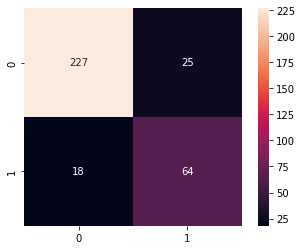

In [86]:
print_scores(best_model, y_test, X_test)

### Sanity Check

In [89]:
data['ml_tag'] = best_model.predict(data['text'])

In [90]:
data

,tweet_id,text,tag,ml_tag
0,1297680994309419008,City coyote out for an afternoon stroll in Bue...,1.0,1.0
1,252225014462558208,"At Mission Trails, This Land is Your Land! -Sc...",0.0,0.0
2,1261350788825182208,See? This that ish I’m talking about. What am ...,1.0,1.0
3,843862456502046725,"#BorregoInSpringtime @ Coyote Canyon, Anza-Bor...",0.0,0.0
4,430034569015070720,Man it is wet! (@ Coyote Valley Sporting Clays...,0.0,0.0
...,...,...,...,...
995,474969582298361857,I hate My Coyote 😠 This shit acts stupid on me! 😠,0.0,1.0
996,1352399273216806913,This is actually super interesting. A team lik...,0.0,0.0
997,348976231179485187,maybe we can give Nic one of those little umbr...,0.0,0.0
998,1111766133059674112,Fort Benning officials have reportedly sanctio...,1.0,0.0


# Save baseline model

In [91]:
joblib.dump(best_model, '../../../models/baseline_cvsvm.pkl')

['../../../models/baseline_cvsvm.pkl']

In [92]:
m = joblib.load('../../../models/baseline_cvsvm.pkl')

In [96]:
m.predict(['I saw a coyote across the street at the restaurant blah blah blah', 'blah blah blah'])

array([1., 0.])